# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
1. Your code must run without errors. Make sure your `numpy` version is at least 1.15.4 and that you are using at least python 3.6. Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: 203074224_208930503

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [37]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)


In [38]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)


## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [39]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')
data.shape

(8124, 22)

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [40]:
#############################################################################
# TODO: Find columns with missing values and remove them from the data.#
#############################################################################

# Drop rows with null values
data = data.dropna(axis=0, how='any')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

We will split the dataset to `Training` and `Testing` datasets.

In [41]:
from sklearn.model_selection import train_test_split

# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)
   

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [42]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [43]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    gini = 1.0
    #conveting to pd, so we could use valuecounts to calc pi for every class under last colum
    #last_column = pd.DataFrame(data[:,-1]) 
    #numofclasses=last_column.value_counts().shape[0]
    #for i in range (numofclasses):
    #    gini -= (last_column.value_counts(normalize=True)[i])**2
    clm=data[:,-1]
    attributes = np.unique(clm)
    for attribute in attributes:
        gini -= (data[data[:,-1]==attribute].shape[0]/data.shape[0])**2

    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return gini

In [44]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    entropy = 0.0
    clm=data[:,-1]
    attributes = np.unique(clm)
    for attribute in attributes:
        pi=data[data[:,-1]==attribute].shape[0]/data.shape[0]
        entropy -= pi*np.log2(pi)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return entropy

In [45]:
##### Your Tests Here #####
#print(X[X[:,-1]=="p"])
#print(X[X[:,-2]=="p"])
calc_gini(X[X[:,0]=="x"]), calc_entropy(X[X[:,21]=="e"])
calc_gini(X[X[:,0]=="x"]), calc_entropy(X)




(0.4986495925285732, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [46]:
#define the Split in Information func, very similar to clac_entrpoy, will be used in the next block of code
def split_in_information(data, feature):
    entropy = 0.0
    clm=data[:,feature]
    attributes = np.unique(clm)
    for attribute in attributes:
        pi=data[data[:,feature]==attribute].shape[0]/data.shape[0]
        entropy -= pi*np.log2(pi)
    return entropy

def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    weighted_average = 0.0
    #creating array of unique attributes 
    attributes = np.unique(data[:,feature])
    for attribute in attributes:
        weight = data[data[:,feature]==attribute].shape[0]/data.shape[0]
        weighted_average += weight*impurity_func(data[data[:,feature]==attribute])
    goodness = impurity_func(data) - weighted_average
    if (gain_ratio):
        goodness = goodness/split_in_information(data, feature)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return goodness

#print(goodness_of_split(X, -1, calc_gini))
#print(X[X[:,1]=="b"])
#print(X.shape[1])

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [47]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, feature, data, value):
        self.feature = feature # column index of criteria being tested
        self.value = value
        self.data = data #to hold the sub group of instances, defined by the values along path from root
        self.children = [] #list of children
        self.parent = None #parent pointer
        self.depth = 0
        self.prob =  self.get_prob() 
    
    # probability for edibility, based on current route 
    def get_prob (self):
        p_e=self.data[self.data[:,-1]=="e"].shape[0]/self.data.shape[0]
        return p_e
    
    # When adding a child, we update the self to be the parent, 
    # we update the depth of the child to be +1 the debt of the parent..
    # debth can cause some problem - when adding a child that is also a parent, the depth of his children
    # wont be updated, so  BFS operation is needed on the new child. 
    def add_child(self, child):
        self.children.append(child)
        child.parent = self
        child.depth = self.depth + 1 

    #unique array defined by feature and currnt data the node holds, children can be defined by it while building the tree
    def get_values(self):
        return np.unique(self.data[:,self.feature])

def isLeaf(node):
    return (len(node.children)==0)

def find_best_feature(data, impurity, gain_ratio):
    best_feature = (data.shape[1] + 1) #for creating an error messege
    max_split_val = -float("inf")
    for feature in range(data.shape[1]-1): #last colum isn't a feature, its the lable.
        temp_split_val = goodness_of_split(data, feature, impurity, gain_ratio)
        #print("feature in test:" , feature, "goodness:", temp_split_val)
        if (temp_split_val > max_split_val):
            max_split_val = temp_split_val
            best_feature = feature 
    return best_feature 

In [48]:
def build_tree(data, impurity, gain_ratio=False, min_samples_split=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    stack = []
    #best first feature to split by:
    best_feature = find_best_feature(data, impurity, gain_ratio)
    root = DecisionNode(best_feature, data, None)    
    stack.append(root)
    while (len(stack) > 0):
        parent = stack.pop()
        isPure = (parent.prob==1.0) or (parent.prob==0.0)
        if (parent.feature == (data.shape[1] + 1)): continue
        if ((parent.depth >= max_depth) or (parent.data.shape[0] <= min_samples_split) or (isPure)) : continue
        if (goodness_of_split(parent.data, parent.feature, impurity, gain_ratio)==0.0): continue
        values = parent.get_values()
        for value in values:
            child_data = parent.data[parent.data[:,parent.feature] == value]
            child_feature = find_best_feature(child_data, impurity, gain_ratio)
            child = DecisionNode(child_feature, child_data, value)
            parent.add_child(child)
            stack.append(child)
        
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root

In [49]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_gini_gain_ratio = build_tree(data=X_train, impurity=calc_gini, gain_ratio=True) # gini and gain ratio
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio
#print_tree(tree_entropy)


## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [50]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    prob = 0.0
    child_exist = True 
    while((node.prob != 1) and (node.prob != 0.0) and (node.feature != instance.shape[0]+1 ) and (child_exist)):
        child_exist = False
        for child in node.children:
            if (instance[node.feature]==child.value):
                node = child
                prob = child.prob
                child_exist = True
                break #child if found, can exit the for loop
            
    if (prob>0.5):
        pred ="e" 
    else: pred = "p"
        
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return pred

In [51]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    for row in range(dataset.shape[0]):
        if (dataset[row,-1] == predict(node, dataset[row,:])):
            accuracy +=1
    accuracy /= dataset.shape[0]
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [52]:
print("Gini train acc:", calc_accuracy(tree_gini, X_train), "test acc:", calc_accuracy(tree_gini, X_test))
print("Entropy train acc:", calc_accuracy(tree_entropy, X_train), "test acc:", calc_accuracy(tree_entropy, X_test))
print("Gini & Gain train acc:", calc_accuracy(tree_gini_gain_ratio, X_train), "test acc:   ", calc_accuracy(tree_gini_gain_ratio, X_test))
print("Entropy & Gain train acc:", calc_accuracy(tree_entropy_gain_ratio, X_train), "test acc:", calc_accuracy(tree_entropy_gain_ratio, X_test))

Gini train acc: 0.9924503528639422 test acc: 0.7769571639586411
Entropy train acc: 0.9940915805022157 test acc: 0.7813884785819794
Gini & Gain train acc: 0.9954045626128344 test acc:    0.7897587395371738
Entropy & Gain train acc: 0.9963892991957984 test acc: 0.7902511078286558


## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.

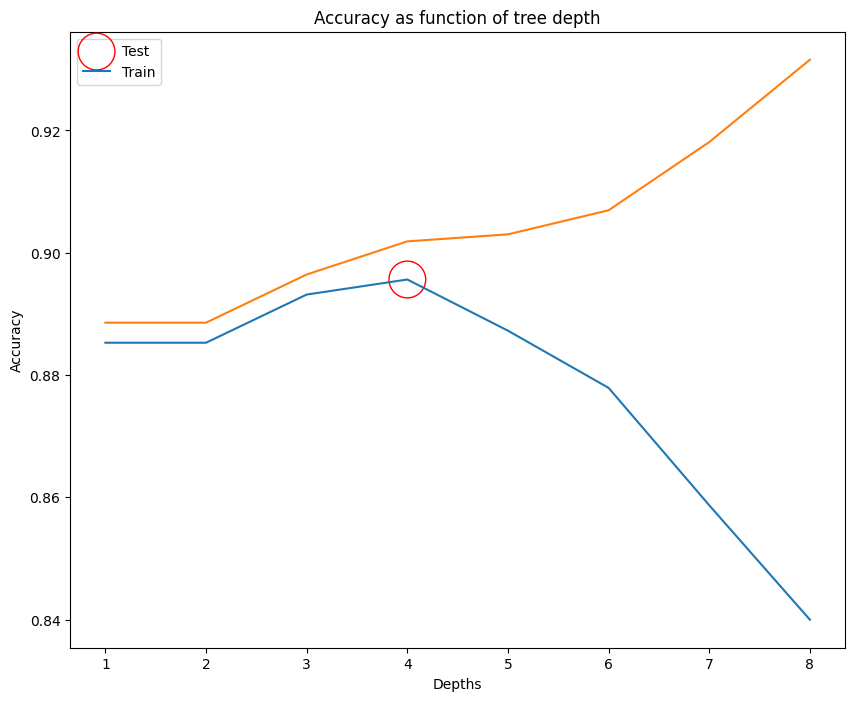

In [53]:
#### Your code here ####
depths = np.array([1,2,3,4,5,6,7,8])
acc_test = {}
acc_train = {}
for depth in depths:
    temp_tree=build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=depth)
    acc_test[depth]=calc_accuracy(temp_tree,X_test)
    acc_train[depth]=calc_accuracy(temp_tree,X_train)

bestdepth = max(acc_test, key=acc_test.get)
plt.scatter(bestdepth, acc_test[bestdepth], s=700, color='None',edgecolor = 'r')
plt.plot(acc_test.keys(), acc_test.values())
plt.plot( acc_train.keys(), acc_train.values())
plt.legend(['Test','Train'])
plt.xlabel('Depths')
plt.ylabel('Accuracy')
plt.title('Accuracy as function of tree depth')
plt.show() 

## Min Samples Split

(15 points)

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)

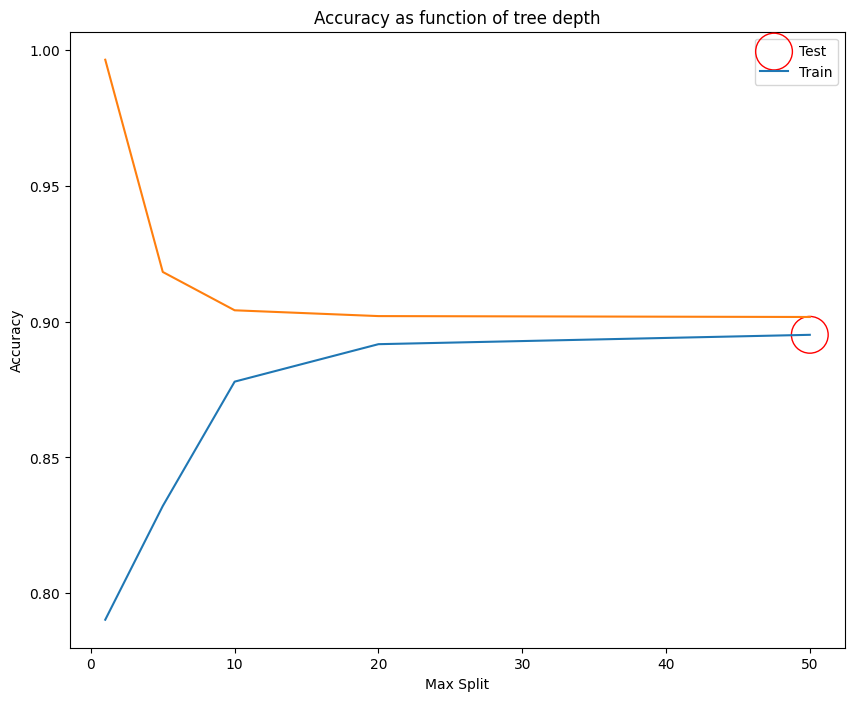

In [19]:
splits = np.array([1,5,10,20,50])
acc_test = {}
acc_train = {}
for split in splits:
    temp_tree=build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=split)
    acc_test[split]=calc_accuracy(temp_tree,X_test)
    acc_train[split]=calc_accuracy(temp_tree,X_train)

bestsplit = max(acc_test, key=acc_test.get)
plt.scatter(bestsplit, acc_test[bestsplit], s=700, color='None',edgecolor = 'r')
plt.plot(acc_test.keys(), acc_test.values())
plt.plot( acc_train.keys(), acc_train.values())
plt.legend(['Test','Train'])
plt.xlabel('Max Split')
plt.ylabel('Accuracy')
plt.title('Accuracy as function of tree depth')
plt.show() 

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [20]:
tree_max_depth = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=bestdepth)
tree_min_samples_split = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=bestsplit)


## Number of Nodes

(5 points)

Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

In [21]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    counter = 1
    for child in node.children:
        counter += count_nodes(child)
    return counter 
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
print(count_nodes(tree_max_depth))
print(count_nodes(tree_min_samples_split))

205
349


## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [22]:
# you can change the function signeture
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    string = ""
    for i in range(node.depth):
        string += "  "
    if isLeaf(node):
        instances=node.data.shape[0]
        print(string, "[", parent_feature, ", leaf]: [{e:",round(node.prob*instances),", p:", round((1.0-node.prob)*instances), "}]" )
    else:
        print(string, "[", parent_feature, ", feature =", feature_val, "]")
    for child in node.children:
        temp = str(node.feature) + "=" + str(child.value)
        print_tree(child,parent_feature=temp,feature_val=child.feature)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
#print_tree(tree_min_samples_split,feature_val=tree_min_samples_split.feature )

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [23]:
splits = np.array([1,5,10,20,50])
depths = np.array([1,2,3,4,5,6,7,8])

#finally_over = DecisionNode(None, None, None)
max_acc=0.0
for split in splits:
    for depth in depths: 
        temp_tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=split, max_depth=depth)
        temp_acc = calc_accuracy(temp_tree, X_test)
        if (count_nodes(temp_tree)<50) and (temp_acc>max_acc):
            max_acc = temp_acc
            finally_over=temp_tree
print("The Best tree with the split and depth combintaion, that has less than 50 nodes is:")
print_tree(finally_over ,feature_val=finally_over.feature)

The Best tree with the split and depth combintaion, that has less than 50 nodes is:
 [ ROOT , feature = 4 ]
   [ 4=a , leaf]: [{e: 273 , p: 31 }]
   [ 4=c , leaf]: [{e: 10 , p: 137 }]
   [ 4=f , leaf]: [{e: 170 , p: 1438 }]
   [ 4=l , leaf]: [{e: 272 , p: 27 }]
   [ 4=m , leaf]: [{e: 2 , p: 25 }]
   [ 4=n , leaf]: [{e: 2332 , p: 344 }]
   [ 4=p , leaf]: [{e: 8 , p: 175 }]
   [ 4=s , leaf]: [{e: 38 , p: 380 }]
   [ 4=y , leaf]: [{e: 49 , p: 382 }]
